# Work 2nd-5th February

Determine the number of iterations needed to reach convergence and the final loss value attained for a series of defocus values.

In [1]:
import pyms
import numpy as np
import torch
import time
from pyms.Probe import aberration
from copy import deepcopy
import matplotlib.pyplot as plt
import math

from pyms.utils.torch_utils import (
    amplitude,
    crop_to_bandwidth_limit_torch,
    size_of_bandwidth_limited_array,
    amplitude,
)

from pyms.Probe import (
    make_contrast_transfer_function,
)

%matplotlib inline


crystal = pyms.structure.fromfile(
    "/home/hremadmin/py_multislice_differentiable/py_multislice_differentiable_tem/Demos/Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
)

# A few maniupulations to remove vaccuum at edges and create a psuedo-periodic structure
crystal = crystal.resize([0.1, 0.76], axis=0)

other = deepcopy(crystal).resize([0.017, 0.99], axis=0)
other.reflect([0])
crystal = crystal.concatenate(other, axis=0)

# Subslicing of crystal for multislice
subslices = [0.33, 0.66, 1.0]

# Grid size in pixels
gridshape = [1024, 1024]

# Tile structure in multislice for a square grid
tiling = [1, 7]

# Probe accelerating voltage in eV
eV = 3e5

# Objective aperture in mrad
app = 15

# Set up series of thicknesses
thicknesses = np.array([100])


In [2]:
# Establish aberrations

def establish_aberrations(df_value):
    """Create a list of aberrations. Initialise with starting values."""

    aberrations = []

    # Initial guesses for aberrations
    df = df_value # This will set the aberrations to the GT (i.e. the optimization SHOULD change nothing, but this wasn't what was seen)
    
    # Cs = 1 mm
    cs = 1e7
    

    # Krivanek aberration coefficient, Haider aberration coefficient, colloquial name, amplitude, angle, n, m
    # n and m are constants (shouldn't be differentiable), amplitude and angle should be

    aberrations.append(aberration("C10", "C1", "Defocus          ", torch.tensor([df], requires_grad = True), 0.0, 1, 0.0))
    aberrations.append(aberration("C30", "C3", "3rd order spher. ", torch.tensor([cs], requires_grad = False), 0.0, 3, 0))
    
    return aberrations


In [4]:
# Set up our initial guess for the crystal HRTEM
# It uses the aberrations (including defocus) as set above

def create_initial_guess(aberrations, aperture):

    output = pyms.HRTEM(
        crystal,
        gridshape,
        eV,
        aperture,
        thicknesses,
        subslices=subslices,
        aberrations=aberrations,
        df= aberrations[0].amplitude,
        tiling=tiling,
        nfph=1,
        showProgress='notebook', 
        apply_ctf = False,
    )
    
    return output

In [5]:
def save_sim_image(sim_image, defocus, aperture):
    plt.imshow(sim_image[0].detach().cpu().numpy())
    
    plt.title(u'Simulated image of SrTiO\u2083/CeO\u2082 interface\n after 2000 iterations')
    
    filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Feb_5/Images/simulated_image_"+ str(defocus) + "_" + str(aperture) + ".jpg"
    filepath_2 = "/home/hremadmin/Documents/Project/ML_files/Work_Feb_5/Torch_Data/image_data_"+ str(defocus) + "_" + str(aperture) + ".pt"
    
    plt.xticks([])
    plt.yticks([])

    plt.savefig(filepath, dpi=500)
    torch.save(sim_image, filepath_2)


In [6]:
def optimise(aberrations, output, ref_data, n_iters, learning_rate, loss_multiplier, defocus, aperture):
    """Go through and refine the aberrations to minimise difference between initial guess (output) and experimental image"""

    bw_limit_size = size_of_bandwidth_limited_array(gridshape)
    rsize = np.asarray(crystal.unitcell[:2]) * np.asarray(tiling)

    curves = []
    params = []

    for i in range(0, len(aberrations)):
        if aberrations[i].amplitude.requires_grad == True:
            params.append(aberrations[i].amplitude)
            curves.append([])

    optimizer = torch.optim.Adam(params, lr = learning_rate)
    criterion = torch.nn.MSELoss()

    loss_curve = []


    start = time.time()

    for iter in range(n_iters):
        ctf = (
                torch.stack(
                    [
                        make_contrast_transfer_function(
                            bw_limit_size, rsize, eV, app, df=aberrations[0].amplitude, aberrations=aberrations
                        )
                    ]
                )
            .type(torch.complex128)
            .to('cpu')
        )

        sim_image = amplitude(torch.fft.ifftn(ctf * output, dim=(-2, -1)))

        optimizer.zero_grad()

        loss = criterion(sim_image, ref_data)*loss_multiplier

        loss.backward()

        optimizer.step()

        loss_curve.append(loss.item())

        
        # What do I want to do with this data? Maybe keep it on hold until 
        for i in range(0,len(curves)):
            curves[i].append(aberrations[i].amplitude.item())


    end = time.time()
    
    runtime = end-start
    
    save_sim_image(sim_image, defocus, aperture)
    
    return runtime, loss.item(), aberrations[0].amplitude.item()


In [ ]:
def generate_experimental_data(defocus, aperture):
    """Generate different starting experimental 'dummy' images"""
    
    subslices = [0.33, 0.66, 1.0]
    gridshape = [1024, 1024]
    tiling = [1, 7]
    eV = 3e5
    app = aperture
    thicknesses = np.array([100])
    df = np.array([defocus])

    aberrations = []
    aberrations.append(aberration("C10", "C1", "Defocus          ", defocus, 0.0, 1, 0.0))
    aberrations.append(aberration("C30", "C3", "3rd order spher. ", 1e7, 0.0, 3, 0))
    
    output = pyms.HRTEM(
        crystal,
        gridshape,
        eV,
        app,
        thicknesses,
        subslices=subslices,
        aberrations=aberrations,
        df=df,
        tiling=tiling,
        nfph=1,
        showProgress='notebook'
    )
    
    plt.imshow(output, vmin=0)# failing on this line if df is a tensor, fine if its a np array

    plt.title(u'Dummy image for SrTiO\u2083/CeO\u2082 interface\n defocus={defocus}Å 1 frozen phonon pass Cs = 1mm\naperture={aperture}mrad'.format(defocus=defocus, aperture=aperture), fontsize=15)
    plt.xticks([])
    plt.yticks([])

    filepath = '/home/hremadmin/Documents/Project/ML_files/Work_Feb_5/experimental_images/def_{defocus}_ap_{aperture}.jpg'.format(defocus=int(defocus), aperture=int(aperture))
    
    plt.savefig(filepath, dpi=500, bbox_inches="tight")
    
    return output

In [8]:
def main(n_iters, learning_rate, loss_multiplier, defocus, aperture):
    aberrations = establish_aberrations(defocus)
    output = create_initial_guess(aberrations, aperture) # Modified to use the same aperture as the experimental data
    
    # Load in "experimental" data
    
    ref_data = generate_experimental_data(defocus, aperture)
    ref_data = torch.tensor(ref_data).to('cpu')
    
    runtime, loss, defocus_final = optimise(aberrations, output, ref_data, n_iters, learning_rate, loss_multiplier, defocus, aperture)
    return runtime, loss, defocus_final
    
    

In [9]:
def save_data(variables, runtimes, losses, defocus_values, defocus, aperture):
    filename = '/home/hremadmin/Documents/Project/ML_files/Work_Feb_5/CSV_data/Iterations_{defocus}_{aperture}.csv'.format(defocus=defocus, aperture=aperture)
    x= "Iterations, Loss, Final defocus value, time to run"
    
    f = open(filename, "a")
    f.write(x)
    f.write("\n")

    for i in range(0, len(variables)):
        line = str(variables[i]) +  ", " + str(losses[i]) + ", " + str(defocus_values[i]) + ", " + str(runtimes[i])
        f.write(line)
        f.write("\n")

    f.close() 
    

In [10]:
def save_plots(variable_data, losses, defocus_values, defocus, aperture):
    y_label_1 = "Loss"
    y_label_2 = "Final defocus value"
    x_label = "Number of iterations"
    
    filepath_1 = '/home/hremadmin/Documents/Project/ML_files/Work_Feb_5/Loss_{defocus}_{aperture}.jpg'.format(defocus=defocus, aperture=aperture)
    filepath_2 = '/home/hremadmin/Documents/Project/ML_files/Work_Feb_5/Defocus_{defocus}_{aperture}.jpg'.format(defocus=defocus, aperture=aperture)
    
    plt.clf()
    plt.plot(variable_data, losses)
    plt.ylabel(y_label_1)
    plt.xlabel(x_label)
    plt.savefig(filepath_1, dpi=500, bbox_inches="tight")
    plt.clf()
    
    plt.plot(variable_data, defocus_values)
    plt.ylabel(y_label_2)
    plt.xlabel(x_label)
    plt.savefig(filepath_2, dpi=500, bbox_inches="tight")
    plt.show()
    

# Quick madness interlude

In [28]:
E = 3e5 * 1.6e-19
c = 3e8
h = 6.626e-34
wavelength = (c*h)/E * 1e10 # in angstroms

print(wavelength)

wavevector = 1/wavelength  * 2 * 3.14
print(wavevector)

# g= k * theta
#g = 15e-3 * wavevector

g = 1/532 * 2 * 3.14

theta = g / wavevector

print(theta*1000)

print(wavelength/532)


0.0414125
151.64503471174163
0.07784304511278195
7.784304511278195e-05


In [32]:
wavelength = 0.0224
wavevector = 1/wavelength 
print(wavevector)

g = 15e-3 * wavevector

print(g)

44.642857142857146
0.6696428571428572


# End of madness interlude

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

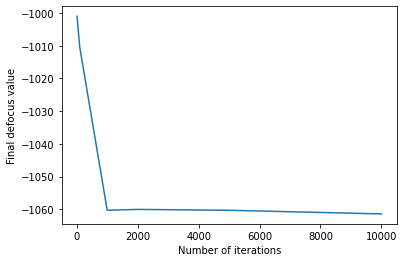

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

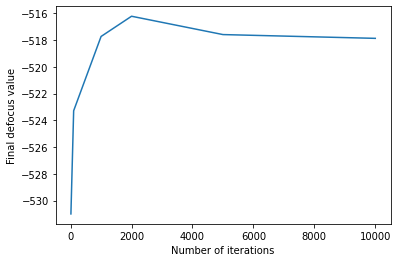

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

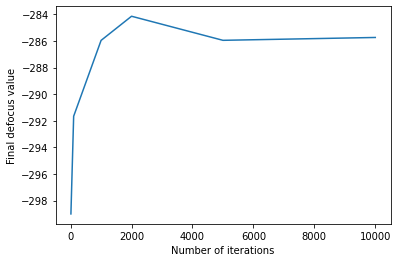

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Lowena-modified code
False


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

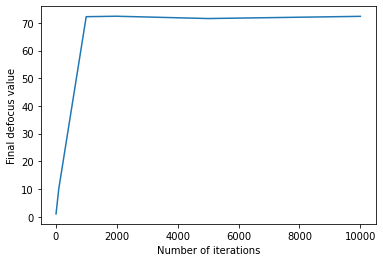

Total runtime:  4532.113437652588


In [14]:
n_iterations = [10, 100, 1000, 2000, 5000, 10000]

# Constants
learning_rate = 1e-1
loss_multiplier = 1e9

experimental_defocus = [-1000.0, -532.0, -300.0, 0.0]
experimental_apertures = [4.25, 9.3, 6.3, 7.9] # corrected the aperture for the Scherzer defocus to be 9.3 instead of 5.5

# -532, app = 9.3
# -1000 app = 4.25
# -300 app = 6.3
# 0 app = 7.9

st = time.time()

for x in range(0, len(experimental_defocus)):
    exp_defocus = experimental_defocus[x]
    exp_aperture = experimental_apertures[x]
    runtimes = []
    losses = []
    defocus_values = []
    for j in n_iterations:
        runtime, loss, defocus_final = main(j, learning_rate, loss_multiplier, exp_defocus, exp_aperture)
        runtimes.append(runtime)
        losses.append(loss)
        defocus_values.append(defocus_final)
        
    save_data(n_iterations, runtimes, losses, defocus_values, exp_defocus, exp_aperture)
    save_plots(n_iterations, losses, defocus_values, exp_defocus, exp_aperture)

et = time.time()

time_to_run = et - st

print("Total runtime: ", str(time_to_run))

Okay comments: <br>

We started our optimization at the GT in each case: this case probably not the best plan, instead we should probably start a set distance away (say 100) <br>

From results what I noticed is that even though we started at GT, often we deviated significantly from it. <br>

I wonder why. <br>


I do NOT GET how to calculate the aperture.

In [9]:
# To calculate the Scherzer_defocus

from pyms.Probe import (
    make_contrast_transfer_function,
    Scherzer_defocus
)

Cs = 1e7 # 1 mm
eV = 3e5

sdf = Scherzer_defocus(eV, Cs)
print(sdf)

energy = 3e5 * 1.6e-19
c = 3e8
h = 6.626e-34
k = energy / (c*h)

#print(k) # this is in m^-1

k_A = k / 1e10
print(k_A) # 24 A^-1

# scherzer defocus to interplanar spacing?


theta = k_A / sdf
print(theta)


-532.4470209426454
24.147298520977962
-0.04535155155573512


300 keV == 300 * 1000 * 1.6 x 10^-19 = 4.8 x 10^-14 J
E = hc/lambda
Wavevector, k = 1/lambda = E/hc = 2.41 x 10^11 m??

g = k * theta

g is the planar spacing, k is the wavevector

How do we know the planar spacing? of the crystal? waaa